## Convolutional Neural Networks - Hymenoptera Dataset

In [173]:
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from Plot import plot_image_grid

## 🍳 Data Preparation

In [73]:
train_dataset = keras.utils.image_dataset_from_directory(
    directory='./data/Hymenoptera/train',
    labels='inferred',                              
    label_mode='int',                              
    batch_size=32,                      # comes batched!                            
    image_size=(224, 224),                         
    seed=42  
)

val_dataset = keras.utils.image_dataset_from_directory(
    directory='./data/Hymenoptera/val',
    labels='inferred',                              
    label_mode='int',                              
    batch_size=32,                                  
    image_size=(224, 224),                         
    seed=42  
)

Found 244 files belonging to 2 classes.
Found 153 files belonging to 2 classes.


In [146]:
# Define mean and variance for normalization
mean = [0.5, 0.5, 0.5]
var = [0.25, 0.25, 0.25]

# Training transformations
def train_transformations(x):
    x = layers.RandomCrop(height=224, width=224)(x)
    x = layers.RandomFlip(mode="horizontal")(x)
    x = layers.Normalization(mean=mean, variance=var)(x)
    return x

# Validation Transformations
def val_transformations(x):
    x = layers.CenterCrop(height=224, width=224)(x)
    x = layers.Normalization(mean=mean, variance=var)(x)
    return x

# Custom conditional layer
class ConditionalTransformationsLayer(layers.Layer):
    def __init__(self):
        super(ConditionalTransformationsLayer, self).__init__()

    def call(self, inputs, training=None):
        if training:
            return train_transformations(inputs)
        else:
            return val_transformations(inputs)

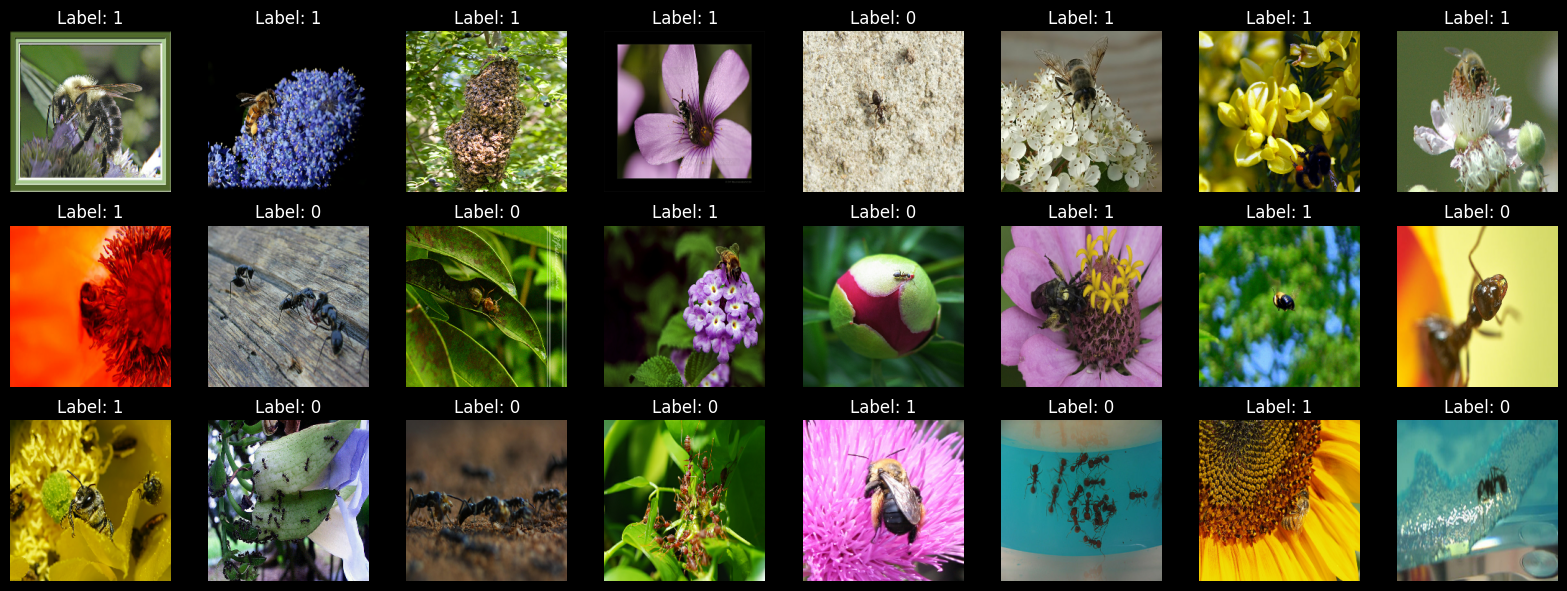

In [147]:
flat_train_dataset = []
for batch_images, batch_labels in train_dataset.as_numpy_iterator():
    flat_train_dataset.extend(zip(batch_images, batch_labels))
plot_image_grid(flat_train_dataset)

## 🚢 Model Building

<img src="https://i.imgur.com/CdbdFDe.png">

In [154]:
# Define a simple CNN model: let's use functional/sequential API this time
def SimpleCNN():
    model = keras.Sequential()
    
    # Add input later
    model.add(keras.Input(shape=(224, 224, 3)))
    
    # Add transformations layer
    model.add(ConditionalTransformationsLayer())
    
    # CNN
    model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))  # [224, 224, 3] -> [224, 224, 16]
    model.add(layers.MaxPooling2D((2, 2)))      
    
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))  
    model.add(layers.MaxPooling2D((2, 2)))  
    
    # Flatten the output from the conv layers
    model.add(layers.Flatten())  
    
    # Add a fully connected (dense) layer
    model.add(layers.Dense(1))
    # Notice that we didn't need to do the math throughout to figure out the input shape as in PyTorch
    # technically, PyTorch has LazyLinear but it's been experimental for some time (likely no longer)
    
    return model

If we want it to be purely functional, we can do:

In [155]:
def SimpleCNNF():
    inputs = keras.Input(shape=(224, 224, 3))
    
    # Add convolutional layers
    a = ConditionalTransformationsLayer()(inputs)
    a = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(a)
    a = layers.MaxPooling2D((2, 2))(a) 
    
    a = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(a)  
    a = layers.MaxPooling2D((2, 2))(a)  
    
    # Flatten the output from the conv layers
    a = layers.Flatten()(a)  
    
    # Add a fully connected (dense) layer
    outputs = layers.Dense(1)(a)  
    
    # Create the model
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

Notice that unlike the PyTorch example we use a single neuron in the output (loss will have sigmoid) for brevity.

In [157]:
model = SimpleCNN()                            # We will stick with this here but you can switch
modelF = SimpleCNNF()
assert model.summary() == modelF.summary()

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conditional_transformations_la… │ (None, 224, 224, 3)    │             0 │
│ (ConditionalTransformationsLay… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,441 (411.88 KB)

 Trainable params: 105,441 (411.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_64 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conditional_transformations_la… │ (None, 224, 224, 3)    │             0 │
│ (ConditionalTransformationsLay… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │       100,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,441 (411.88 KB)

 Trainable params: 105,441 (411.88 KB)

 Non-trainable params: 0 (0.00 B)

## 💪 Model Training

In [158]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [162]:
def train(model, train_dataset, num_epochs=300):
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        # 1. Setup metrics for epoch
        epoch_loss = keras.metrics.Mean()
        for x_batch, y_batch in train_dataset:
            
            # 2. Forward pass and compute loss
            with tf.GradientTape() as tape:
                # next two lines just like PyTorch
                y_pred = model(x_batch, training=True)
                loss = loss_fn(y_batch, y_pred)
            
            # 3. Backward pass
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
             # 4. Update metrics
            epoch_loss.update_state(loss)
        pbar.set_description(f'Epoch {epoch + 1}, Loss: {round(float(epoch_loss.result()), 2)}')

train(model, train_dataset, num_epochs=5)

Epoch 5, Loss: 0.28: 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


## 🕵️ Evaluation

In [163]:
from keras.metrics import Accuracy

def evaluate(model, val_dataset):
    # 1. Setup metrics
    Acc = Accuracy()
    for x_batch, y_batch in val_dataset:
        # 2. Forward pass
        y_pred = model(x_batch, training=False)
        # set 0 or 1 depending on negative or positive
        y_pred_label =  keras.activations.sigmoid(y_pred) > 0.5
        # 3. Update metrics
        Acc.update_state(y_batch, y_pred_label)
    return Acc.result().numpy()

evaluate(model, val_dataset)

0.627451

### ⭐ Equivalently

In [178]:
model = SimpleCNN()
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'], run_eagerly=True)
model.fit(train_dataset, epochs=3, callbacks=[TqdmCallback()], verbose=False)
model.evaluate(val_dataset, return_dict=True)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - accuracy: 0.4815 - loss: 4.1234


{'accuracy': 0.48366013169288635, 'loss': 3.7912230491638184}

### 💻 Deployment

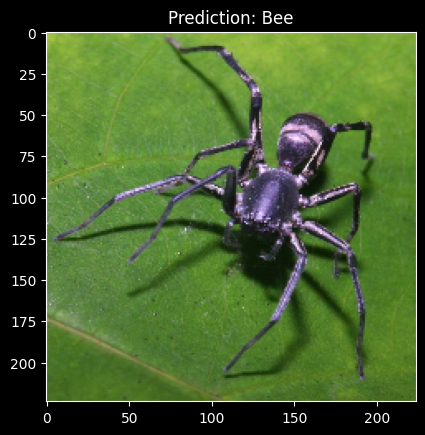

In [193]:
import numpy as np

# load and show some random image
rand_num = np.random.randint(len(flat_train_dataset))
rand_val_img, _ = flat_train_dataset[rand_num]
rand_val_img = np.clip(rand_val_img/255.0, 0, 1)
plt.imshow(rand_val_img)
prediction = np.round(model(rand_val_img[tf.newaxis, ...]))
plt.title(f'Prediction: {"Bee" if prediction[0] == 1 else "Ant"}')
plt.show()

#### 🤔 Can we do better with less effort?

Yes, like we did in PyTorch, by Fine-tuning a pretrained model!

In [201]:
import tensorflow as tf
from keras.applications import ResNet50  
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [203]:
class ModifiedResNet(Model):
    def __init__(self, num_outputs, freeze=False):
        super(ModifiedResNet, self).__init__()
        # Load ResNet50 model pre-trained on ImageNet, excluding the top classification layer
        self.base_model = ResNet50(weights='imagenet', include_top=False)
        if freeze:
            for layer in self.base_model.layers:
                layer.trainable = False
        
        # extra layers we will need to append:
        self.global_avg_pool = GlobalAveragePooling2D()
        self.flatten = Flatten()
        self.dense = Dense(1)

    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        output = self.dense(x)
        return output

# Instantiate the model
resnet_model = ModifiedResNet(num_outputs=1, freeze=True)

# Compile the model with Adam optimizer
resnet_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss=keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=['accuracy'])

resnet_model.fit(train_dataset, epochs=3, verbose=False, callbacks=[TqdmCallback()],)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [204]:
resnet_model.evaluate(val_dataset, return_dict=True)

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8796 - loss: 0.3095


{'accuracy': 0.8627451062202454, 'loss': 0.34539052844047546}

Big difference, right?

<img src="https://i.imgur.com/LgCtYGd.png">